<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Training-on-clean-images-(prior)" data-toc-modified-id="Training-on-clean-images-(prior)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Training on clean images (prior)</a></span></li></ul></li><li><span><a href="#Task-1:-Generation" data-toc-modified-id="Task-1:-Generation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task 1: Generation</a></span></li><li><span><a href="#Task-2:-Denoising" data-toc-modified-id="Task-2:-Denoising-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Task 2: Denoising</a></span></li><li><span><a href="#Task-3:-[inverse-problem]-Inpainting" data-toc-modified-id="Task-3:-[inverse-problem]-Inpainting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Task 3: [inverse problem] Inpainting</a></span></li><li><span><a href="#Task-4:-[inverse-problem]-Gaussian-downsampling" data-toc-modified-id="Task-4:-[inverse-problem]-Gaussian-downsampling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Task 4: [inverse problem] Gaussian downsampling</a></span></li><li><span><a href="#Task-5:-[inverse-problem]-Photoacoustic-Tomography" data-toc-modified-id="Task-5:-[inverse-problem]-Photoacoustic-Tomography-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Task 5: [inverse problem] Photoacoustic Tomography</a></span></li></ul></div>

This notebook presents key results of this project, from generating new FashionMNIST clothes to solving a photoacoustic tomography inverse problem on FashionMNIST images.

We present results on **MNIST** using a **Variance Exploding** (VE) SDE and a **Predictor-Corrector** (PC) sampler for our score-based diffusion model. 

*You can play with the parameters but not all possible combinations may have a pre-trained checkpoint. Retraining from scratch the scorenet model takes between 15 and 30 minutes.*

## Setup

### Imports

In [87]:
import functools
import torch
import tqdm
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import Adam
from torch.utils.data import DataLoader

# if run remotely: import utils from github repo
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    if os.path.isdir('./diffusion-for-photoacoustic/') == False:
        ! git clone https://github.com/snigdhasaha7/diffusion-for-photoacoustic.git
    sys.path.append('./diffusion-for-photoacoustic/')
# if run locally: add parent path
else:
    parent_dir = os.path.dirname(os.getcwd())
    sys.path.append(parent_dir)
    
import samplers
from models import ScoreNet
from sdes import Classic, VarianceExploding, VariancePreserving, SubVariancePreserving
from tasks import AddGaussianNoise, inpaint, gaussian_downsampling, PAT_forward

### Config

In [88]:
n_epochs = 50
batch_size = 64
lr = 1e-4
device = 'cuda'         # ['cuda', 'cpu']
dataset = 'FashionMNIST'    # ['MNIST', 'FashionMNIST', 'CIFAR10']
sde_type = 've'        # ['classic', 'vp', 've', 'subvp']
sde_params = [0.01, 5] # [classic: sigma][vp: b_min, b_max][ve|subve: s_min, s_max]
gen_sampler = 'pc'     # ['em', 'pc', 'ode']
denoise_sampler = 'pc' # ['em', 'pc']
noise_std = .1
training = True
denoising = True
psnr = samplers.psnr

### Setup

In [103]:
# SDE
if sde_type == 've':
    SDE = VarianceExploding()
    sigma_min, sigma_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
elif sde_type == 'vp':
    SDE = VariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'subvp':
    SDE = SubVariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'classic':
    SDE = Classic()
    sigma = sde_params
    params_str = '{}'.format(sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma=sigma)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma=sigma)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma=sigma)
    
# sampler for generation
if gen_sampler == 'em':
    sampler = samplers.Euler_Maruyama_sampler
elif gen_sampler == 'pc':
    sampler = samplers.pc_sampler
elif gen_sampler == 'ode':
    sampler = samplers.ode_sampler

# sampler for denoising
if denoise_sampler == 'em':
    denoiser = samplers.Euler_Maruyama_denoiser
elif denoise_sampler == 'pc':
    denoiser = samplers.pc_denoiser

# training dataset
if training:
    if dataset == 'MNIST':
        train_transforms = transforms.Compose([transforms.ToTensor()])
        train_dataset = MNIST('.', train=True, transform=train_transforms, download=True);
    elif dataset == 'FashionMNIST':
        train_transforms = transforms.Compose([transforms.ToTensor()])
        train_dataset = FashionMNIST('.', train=True, transform=train_transforms, download=True);
    elif dataset == 'CIFAR10':
        train_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
             transforms.Resize((28,28)),
             transforms.Grayscale(num_output_channels=1)])
        train_dataset = CIFAR10('.', train=True, transform=train_transforms, download=True);
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

if denoising:
    if dataset == 'MNIST':
        test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
        test_dataset = MNIST('.', train=False, transform=test_transforms, download=True);
    elif dataset == 'FashionMNIST':
        test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
        test_dataset = FashionMNIST('.', train=False, transform=test_transforms, download=True);
    elif dataset == 'CIFAR10':
        test_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
             transforms.Resize((28,28)),
             transforms.Grayscale(num_output_channels=1),
             AddGaussianNoise(noise_std)])
        test_dataset = CIFAR10('.', train=False, transform=test_transforms, download=True);
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4);

# Set up denoiser
def denoise(raw_images, denoiser, lbda=.5, lbda_schedule='constant', lbda_param=1, operator_P=None,
            subsampling_L=None, transformation_T=None, report_PSNR=False, clean_images=None, 
            num_steps=500, task='denoise'):
    denoised = denoiser(raw_images,
                    score_model,
                    lbda,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    drift_coeff_fn,
                    task,
                    lbda_schedule,
                    lbda_param,
                    operator_P,
                    subsampling_L,
                    transformation_T,
                    num_steps=num_steps,
                    report_PSNR=report_PSNR,
                    clean_images=clean_images, 
                    device=device)
    return denoised

# helper function to plot samples
def plot_before_after(clean_images, imgs_before, imgs_after, title=""):
    assert(imgs_before.shape[0] == imgs_after.shape[0])
    fig, axs = plt.subplots(2, imgs_before.shape[0], figsize=(16, 5))
    for i, image in enumerate(imgs_before):
        axs[0][i].imshow(image.cpu().permute(1, 2, 0).squeeze())
        axs[0][i].set_xticks([])
        axs[0][i].set_yticks([])
    for i, image in enumerate(imgs_after):
        axs[1][i].imshow(image.cpu().permute(1, 2, 0).squeeze())
        axs[1][i].set_xticks([])
        axs[1][i].set_yticks([])
        if clean_images is not None:
            clean = clean_images[i].cpu().permute(1,2,0).squeeze()
            noisy = image.cpu().permute(1,2,0).squeeze()
            psnr_val = psnr(clean, noisy).item()
            axs[1][i].set_title('PSNR: {:.3f}'.format(psnr_val), y=-0.2)
    fig.suptitle(title, size=20)

# model + optimizer
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)

# loss
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

# checkpoint folder varies if on colab or local
if IN_COLAB:
    checkpoint_dir = './diffusion-for-photoacoustic/checkpoints/'
else:
    checkpoint_dir = './checkpoints/'

### Training on clean images (prior)

In [90]:
checkpoint_path = checkpoint_dir+'ckpt_{}_{}epochs_{}_{}.pth'.format(dataset.lower(), n_epochs, sde_type, params_str)

# load checkpoint if existing
if os.path.exists(checkpoint_path): 
    score_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# otherwise train from scratch
else:
    tqdm_epoch = tqdm.notebook.trange(n_epochs)
    for epoch in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        for x, y in train_loader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0] 
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
        torch.save(score_model.state_dict(), checkpoint_path)

## Task 1: Generation

In [91]:
# Set up sampler
def sample(sampler):
    samples = sampler(score_model, 
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    drift_coeff_fn,
                    batch_size, 
                    device=device)
    return samples

  0%|          | 0/500 [00:00<?, ?it/s]

/content/./diffusion-for-photoacoustic/sdes.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift = torch.zeros_like(torch.tensor(x, device=t.device))


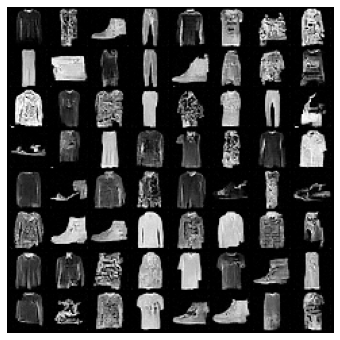

In [92]:
# Generate samples
samples = sample(sampler)
samplers.plot_images(samples)

## Task 2: Denoising


  0%|          | 0/500 [00:00<?, ?it/s]

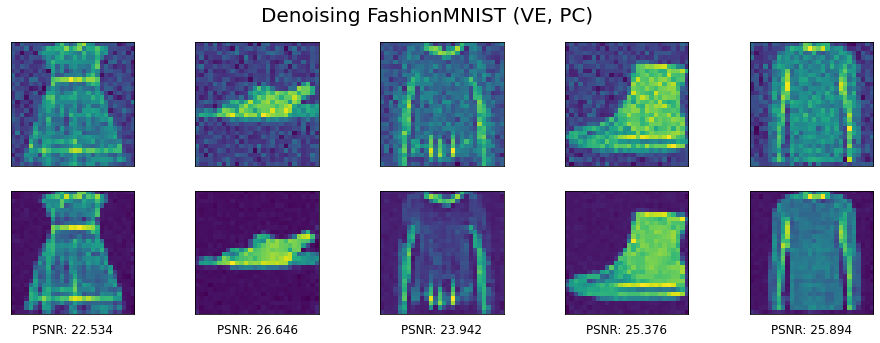

In [93]:
# Clean images
num_images = 5
data, _ = next(iter(train_loader))
clean_images = data[:num_images].to(device)

# Noise up images
noise = AddGaussianNoise(std=0.1)
noisy_images = clean_images.clone();
for i in range(num_images):
    noisy_images[i] = noise(clean_images[i])

# Denoised images
denoised_images, metrics = denoise(noisy_images, denoiser, lbda=.01, lbda_schedule='linear', lbda_param=10,
                                   report_PSNR=True, clean_images=clean_images, task='denoise')


plot_before_after(clean_images, noisy_images, denoised_images, title="Denoising FashionMNIST (VE, PC)")

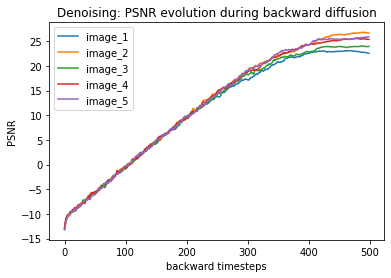

In [94]:
times = range(500)
for i in list(map(list, zip(*metrics))):
    plt.plot(times, i,  markersize = 10, linestyle = 'solid')
plt.legend({'image_1':1, 'image_2': 2, 'image_3': 3, 'image_4': 4, 'image_5': 5},loc ='upper left')
plt.title('Denoising: PSNR evolution during backward diffusion')
plt.xlabel('backward timesteps')
plt.ylabel('PSNR')
plt.show()

## Task 3: [inverse problem] Inpainting

  0%|          | 0/500 [00:00<?, ?it/s]

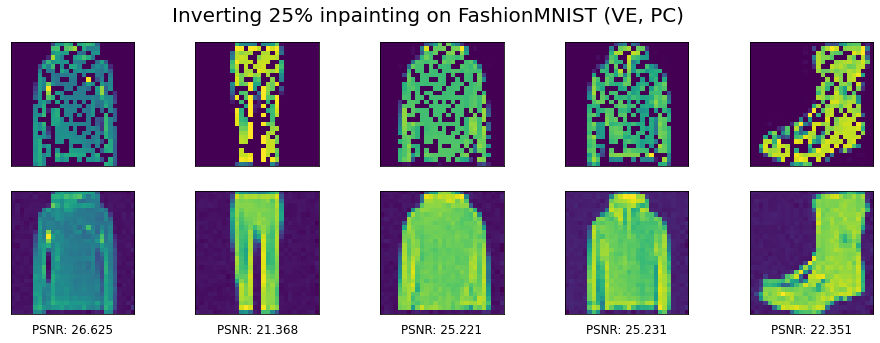

In [96]:
# Inpainted images
num_images = 5
data, _ = next(iter(train_loader))
clean_images = data[:num_images].to(device)
inpainted_images, L = inpaint(clean_images, ratio=0.25)

# Denoised images
denoised_images = denoise(inpainted_images, denoiser, lbda=.01, lbda_schedule='linear', lbda_param=10, subsampling_L=L, task='depaint')

plot_before_after(clean_images, inpainted_images, denoised_images, title="Inverting 25% inpainting on FashionMNIST (VE, PC)")

## Task 4: [inverse problem] Gaussian downsampling

  0%|          | 0/500 [00:00<?, ?it/s]

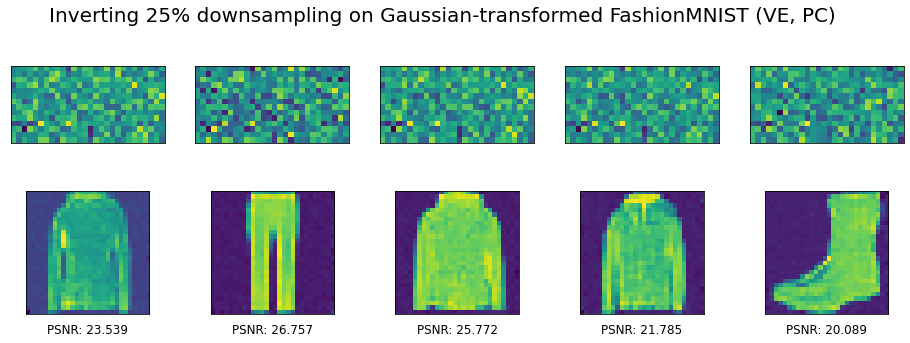

In [98]:
# Gaussian transform + downsampling images
inpainted_images, P, L, T = gaussian_downsampling(clean_images, keep_ratio=0.5)

# Denoised images
denoised_images = denoise(inpainted_images, denoiser, lbda=.01, lbda_schedule='linear', lbda_param=10,
                          operator_P=P, subsampling_L=L, transformation_T=T, task='degaussub')

plot_before_after(clean_images,inpainted_images, denoised_images, title="Inverting 25% downsampling on Gaussian-transformed FashionMNIST (VE, PC)")

## Task 5: [inverse problem] Photoacoustic Tomography

In [99]:
# PAT parameters
# --------------

# Fixed parameters
R_ring         = 0.04
M              = 28
N              = 28
V_sound        = 1500
px             = 1e-3
py             = 1e-3

# Free parameters
N_sample       = 56
N_transducer   = 28

T_min = (R_ring - py * (M / 2 - 0.5)) / V_sound
T_max = np.sqrt((R_ring + py * (M / 2 - 0.5))**2 + (px * (N / 2 - 0.5))**2) / V_sound
dt    = (T_max - T_min) / (N_sample - 1)

oversample  = 10
padsample   = 50
Band        = 1 /dt / 2

PAT_config=[N_transducer, R_ring, px, py, M, N, dt, N_sample, oversample, padsample, T_min, Band, V_sound]

100%|██████████| 28/28 [00:10<00:00,  2.80it/s]


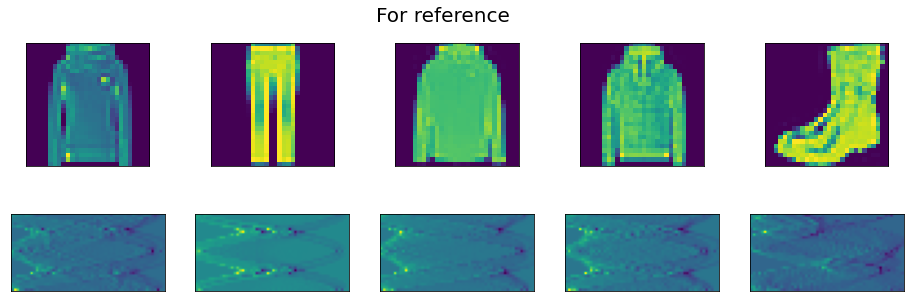

In [104]:
pat_images, P, L, T = PAT_forward(clean_images, PAT_config)
plot_before_after(None, clean_images, pat_images, title="For reference")

  0%|          | 0/500 [00:00<?, ?it/s]

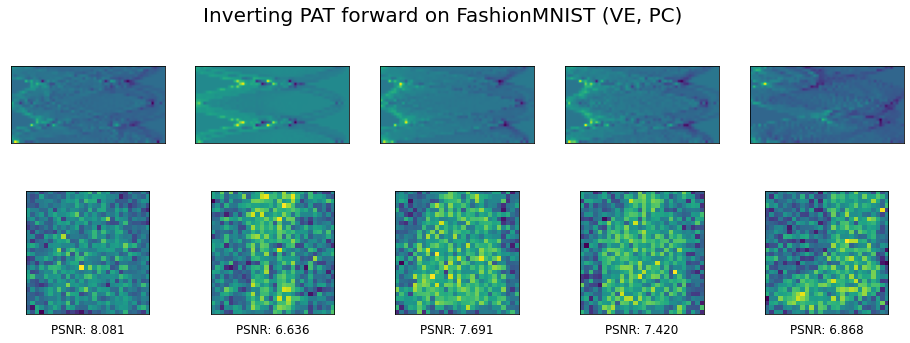

In [106]:
# Denoised images
denoised_images = denoise(pat_images, denoiser, lbda=.02, lbda_schedule='linear', lbda_param=10,
                          operator_P=P, subsampling_L=L, transformation_T=T, num_steps=500, task='depat')

plot_before_after(clean_images, pat_images, denoised_images, title="Inverting PAT forward on FashionMNIST (VE, PC)")

We obtained much crisper results by cranking up the number of timesteps (finer grain temporal transitions)

  0%|          | 0/5000 [00:00<?, ?it/s]

/content/./diffusion-for-photoacoustic/sdes.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift = torch.zeros_like(torch.tensor(x, device=t.device))


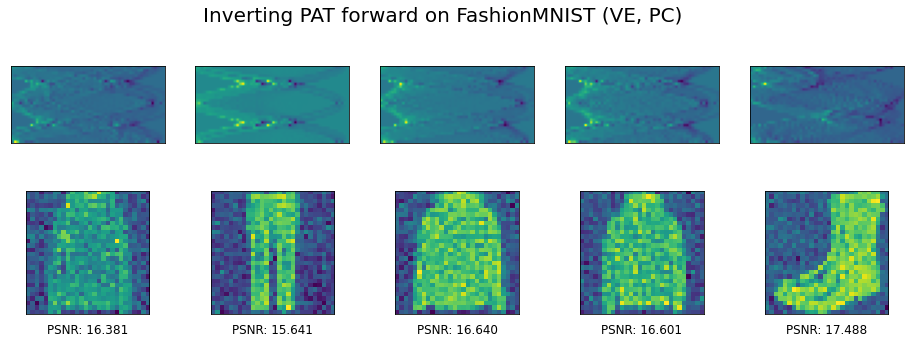

In [107]:
# Denoised images
denoised_images, metrics = denoise(pat_images, denoiser, lbda=.02, lbda_schedule='linear', lbda_param=10,
                          operator_P=P, subsampling_L=L, transformation_T=T, num_steps=5000, 
                          report_PSNR=True, clean_images=clean_images, task='depat')

plot_before_after(clean_images, pat_images, denoised_images, title="Inverting PAT forward on FashionMNIST (VE, PC)")

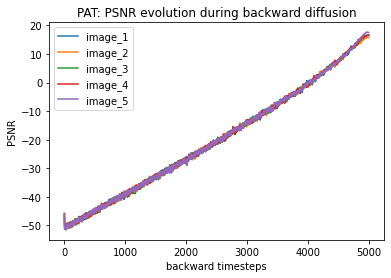

In [108]:
times = range(5000)
for i in list(map(list, zip(*metrics))):
    plt.plot(times, i,  markersize = 10, linestyle = 'solid')
plt.legend({'image_1':1, 'image_2': 2, 'image_3': 3, 'image_4': 4, 'image_5': 5},loc ='upper left')
plt.title('PAT: PSNR evolution during backward diffusion')
plt.xlabel('backward timesteps')
plt.ylabel('PSNR')
plt.show()